Let's use DistilBERT to do the Twitter sentiment analysis task: https://www.kaggle.com/kazanova/sentiment140. The task is to classify tweets as positive (4) or negative (0). I'll relabel to 1 and 0.

Some of this is adapted from the tutorial here: https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d, but on a new dataset (and with some additions).

In [72]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import string
from sklearn.utils import shuffle
import pickle

from tensorflow.keras.callbacks import ModelCheckpoint

import re
import time
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer

from nltk.tokenize import TweetTokenizer # doesn't split at apostrophes
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

from transformers import TFDistilBertModel, DistilBertConfig, DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

import tensorflow.keras 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding

In [2]:
dataset_cols = ["target", "ids", "date", "flag", "user", "text"]
dataset = pd.read_csv('/home/garrett/KagglesData/training.1600000.processed.noemoticon.csv', header=None, encoding='ISO-8859-1', names=dataset_cols)

In [3]:
dataset.shape
dataset.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Put all text in lowercase, remove Twitter handles, punctuation, websites, text in brackets or html tags, and words containing numbers. This does remove words like '2nite', but identifying and parsing 'textspeak' is a challenge that's a little beyond the scope of what I'm trying to investigate here (which is mainly just learning to correctly implement a form of BERT).

In [90]:
def preprocess(text):
    text = text.apply(lambda x: x.lower())
    text = text.apply(lambda x: re.sub(r'@\w+', '', x))
    text = text.apply(lambda x:re.sub('\[.*?\]', '', x))
    text = text.apply(lambda x:re.sub('https?://\S+|www\.\S+', '', x))
    text = text.apply(lambda x:re.sub('<.*?>+', '', x))
    text = text.apply(lambda x:re.sub('[%s]' % re.escape(string.punctuation), ' ', x))
    text = text.apply(lambda x:re.sub('\n', '', x))
    text = text.apply(lambda x:re.sub(' quot ', '', x))
    text = text.apply(lambda x:re.sub('\w*\d\w*', '', x))
    return text

In [91]:
df = shuffle(dataset,random_state=42)
df.head()

,target,ids,date,flag,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


I'm not removing stopwords here, since I think they may contain some useful information about sentiment (things like 'but' and 'not' are likely to be key indicators of negative sentiment in a tweet).

In [92]:
df = df.loc[:, ~df.columns.str.contains('ids', case=False)] 
df = df.loc[:, ~df.columns.str.contains('date', case=False)] 
df = df.loc[:, ~df.columns.str.contains('flag', case=False)]
df = df.loc[:, ~df.columns.str.contains('user', case=False)]
print(df['text'][671155])
df['text']=preprocess(df['text'])
print(df['text'][671155])
#df.tail()

Pickin up @misstinayao waitin on @sadittysash 2 hurry up...I odeeee missed dem  Table talk 2nite...LOL bout to be fat...
pickin up  waitin on   hurry up   i odeeee missed dem  table talk    lol bout to be fat   


Map the target onto a ground-truth of 0  or 1, check to make sure every tweet is labeled.

In [93]:
df['gt'] = df['target'].map({0:0,4:1})
sentences=df['text']
labels=df['gt']
len(sentences),len(labels)

(1600000, 1600000)

In [94]:
df=df.dropna()                 
df=df.reset_index(drop=True)
print('Available labels: ',df['gt'].unique())

Available labels:  [0 1]


Let's do some exploratory data analysis. I'm going to use the whole dataset for this and split into train/val/test after getting the BERT embeddings, since I'm not extracting any features or doing imputation using my EDA- the results from this step won't change my analysis beyond confirming that this is a well-defined problem, so I don't really see a way that data leakage could occur here. 

In [95]:
df['text_len'] = df['text'].astype(str).apply(len)
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))
pos = df[df['gt']==1]
neg = df[df['gt']==0]

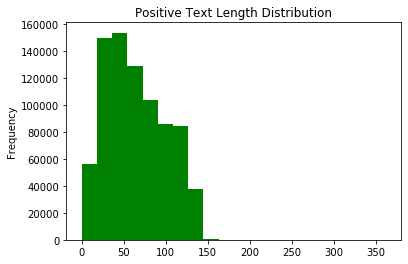

In [96]:
pos['text_len'].plot(
    kind='hist',
    bins=20,
    #xTitle='text length',
    #linecolor='black',
    color='green',
    #yTitle='count',
    title='Positive Text Length Distribution')

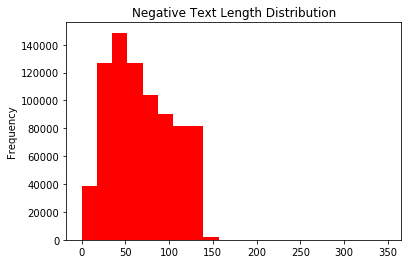

In [97]:
neg['text_len'].plot(
    kind='hist',
    bins=20,
    #xTitle='text length',
    #linecolor='black',
    color='red',
    #yTitle='count',
    title='Negative Text Length Distribution')

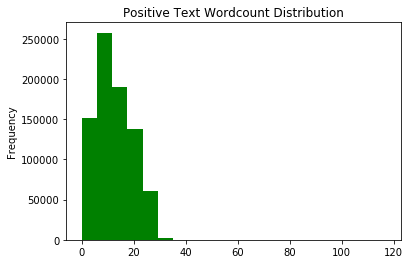

In [98]:
pos['text_word_count'].plot(
    kind='hist',
    bins=20,
    #xTitle='text length',
    #linecolor='black',
    color='green',
    #yTitle='count',
    title='Positive Text Wordcount Distribution')

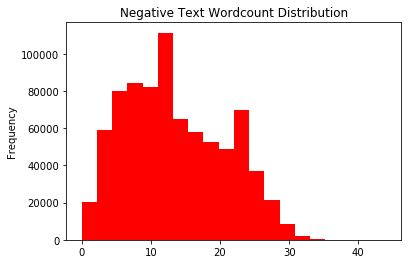

In [99]:
neg['text_word_count'].plot(
    kind='hist',
    bins=20,
    #xTitle='text length',
    #linecolor='black',
    color='red',
    #yTitle='count',
    title='Negative Text Wordcount Distribution')

We see that in general, negative tweets contain slightly more characters, and that positive and negative tweets are similarly distributed in number of words (though with one or more outlier positive tweets containing many short words). Let's look at the common sentiment-indicating words. For this, I will remove stopwords, so the top words aren't just things like 'the' and 'to'.

In [100]:
#source of code : https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    tt = TweetTokenizer()
    vec = CountVectorizer(tokenizer = tt.tokenize, stop_words = stopwords.words('english')).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [101]:
pos_unigrams = get_top_n_words(pos['text'],20)
neg_unigrams = get_top_n_words(neg['text'],20)

In [102]:
tt = TweetTokenizer()
df['tokenized_text'] = df.apply(lambda row: tt.tokenize(row['text']), axis=1)

In [103]:
for i in range(1600000):
    if 'quot' in df['tokenized_text'][i]: print(df['tokenized_text'][i])

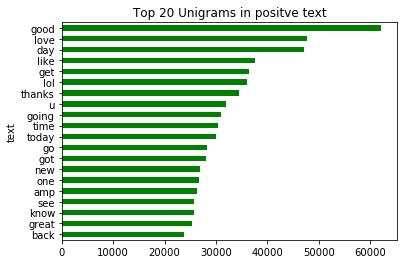

In [104]:
#for word, freq in top_unigrams:
    #print(word, freq)
df1 = pd.DataFrame(pos_unigrams, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(color='green', title='Top 20 Unigrams in positve text')

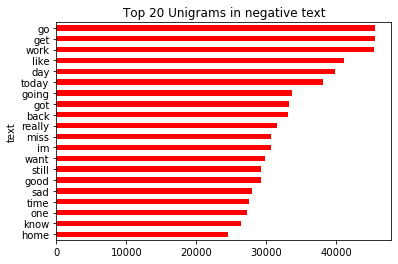

In [105]:
#for word, freq in top_unigrams:
    #print(word, freq)
df1 = pd.DataFrame(neg_unigrams, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(color='red', title='Top 20 Unigrams in negative text')

We can see that the top good words include positive sentiments (things like "good" and "haha") and the top bad words include negative ones ("sad", "miss", "want"). So far, so good! Now let's train BERT.

In [9]:
bert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
bert_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=2)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [10]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [11]:
len(input_ids),len(attention_masks),len(labels)

(1600000, 1600000, 1600000)

In [12]:
print('Preparing the pickle file.....')

pickle_inp_path='./models_and_pickles/bert_inp.pkl'
pickle_mask_path='./models_and_pickles/bert_mask.pkl'
pickle_label_path='./models_and_pickles/bert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Preparing the pickle file.....
Pickle files saved as  ./bert_inp.pkl ./bert_mask.pkl ./bert_label.pkl


In [13]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Loading the saved pickle files..
Input shape (1600000, 64) Attention mask shape (1600000, 64) Input label shape (1600000,)


In [14]:
trainval_inp,test_inp,trainval_label,test_label,trainval_mask,test_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.1)
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(trainval_inp,trainval_label,trainval_mask,test_size=0.1)

In [15]:
log_dir='tensorboard_data/tb_bert'
model_save_path='./models_and_pickles/bert_model.h5'

callbacks = [tensorflow.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tensorflow.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

In [16]:
print('\nBert Model',bert_model.summary())


Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [17]:
history=bert_model.fit([train_inp,train_mask],train_label,batch_size=64,epochs=4,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

Wow, over 90% train accuracy in only 4 epochs! The model is definitely overtraining (val loss is getting worse, no significant gain in accuracy). This is likely due to the relatively small batch size we're working with- the next step for this project would be to run it on a CoLab TPU with much larger batches. Another option would be to fiddle with the learning rate and make it much smaller- however, this would increase train time by quite a bit! For now, 85% accuracy on sentiment analysis is still pretty darn good even if it's clearly suboptimal.

In [23]:
%load_ext tensorboard
log_dir='tensorboard_data/tb_bert'
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Let's do our final eval on the test set:

In [31]:
model_save_path='./models_and_pickles/bert_model.h5'

trained_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

preds = trained_model.predict([test_inp,test_mask],batch_size=64)
pred_labels = np.argmax(preds.logits, axis=1)
f1 = f1_score(test_label,pred_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(test_label,pred_labels))

print('Training and saving built model.....')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_139', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

F1 score 0.851464061623221
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     79922
           1       0.87      0.83      0.85     80078

    accuracy                           0.85    160000
   macro avg       0.86      0.85      0.85    160000
weighted avg       0.86      0.85      0.85    160000

Training and saving built model.....


                     precision    recall  f1-score   support

               0       0.84      0.88      0.86     79922
               1       0.87      0.83      0.85     80078

        accuracy                           0.85    160000
       macro avg       0.86      0.85      0.85    160000
    weighted avg       0.86      0.85      0.85    160000

My conclusions: I've successfully fine-tuned a DistilBERT model and achieved 85% validation accuracy on this sentiment detection Kaggle challenge. We can do better, but this will require both better hardware and longer training time. My next step for this project will be to move to a CoLab notebook and try both larger batches, a smaller LR, and a larger BERT (i.e., not DistilBERT). Thanks for following!